# Rapport Projet Inpainting
Gaël Marcheville et Adrien Coutelle

## I - Introduction

### a) Présentation de la notion d'inpainting

L'inpainting est un processus de traitement d’image qui consiste à compléter une zone inconnue de l'image, en copiant des parties connues de cette dernière. Ainsi, nous pouvons supprimer des éléments d’une image, comme des personnes ou une voiture, en définissant la zone inconnue sur ces éléments. Cette méthode est entièrement déterministe, contrairement à ce qu'on pourrait avoir avec l'intelligence artificielle.

### b) Choix pour la réalisation du projet

Pour ce projet, nous avons choisi de traiter les images comme des tableaux numpy, sans la bibliothèque CV2. L'objectif de cela est de comprendre chacune de nos actions sur les images, afin d'avoir une vision complète de ce qu'effectue notre algorithme, de ne pas avoir de "boite noire" en utilisant openCV.
Nous avons donc développé un programme permettant de réaliser de l'inpainting, à l'aide d'un document fournis par notre encadrant, Monsieur Newson, et rédigé par A.Criminisi, P. Perez et K.Toyama.

Nous avons codé l'ensemble des programmes disponibles dans ce Notebook, en dehors de la fonction de conversion d'une image couleur vers nuances de gris.

Nous avons fait le choix de réaliser l'algorithme général avant de réaliser une à une les fonctions auxquelles il fait appel. Nous avons commencé par nous concentrer sur les fonctions indispensables. Grâce à ce fonctionnement, nous avons pu étudier l'évolution de l'algorithme au fur et à mesure des implémentations.

### c) import nécessaires

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
from skimage.morphology import binary_erosion, square,binary_dilation
from extended_int import int_inf
import time

## II - Préliminaires

### a) Gestion des fichiers

En premier lieu, nous avons implémenté quelques fonctions simples afin de gérer l'importation d'image dans notre répertoire plus facilement. L'objectif est ici de manipuler des images sous forme de tableau numpy à l'aide de skimage.io.

In [2]:
def get_file_name(file_path):
    """
    :param file_path: relative or absolute path
    :return: file name with extension
    """
    L = file_path.split("/")
    return L[-1]

def load_image(path):
    """
    :param path: relative or absolute path
    :return: image as an array and its name
    """
    name = get_file_name(path)
    img = skio.imread(path)
    return img, name

### b) Préparation des images

Avant d'exécuter notre algorithme, il est nécessaire de préparer nos images. Il est intéressant de pouvoir convertir une image couleur en image noir et blanc mais également de convertir des images noir et blanc en image binaire, par exemple pour définir la zone inconnue omega. Pour la conversion de couleurs à noir et blanc, nous avons pondéré les trois channels en fonction de la sensibilité de l'oeil à la lumière afin d'avoir un rendu plus réaliste.
Le but est d'avoir simplement une image sous forme d'array à partir du nom du fichier.

In [4]:
def from_color_to_gray(rgb):
    """
    :param rgb: image in color
    :return: image in gray shades
    """
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    rgb_float = 0.2989 * r + 0.5870 * g + 0.1140 * b
    for i in range(len(rgb_float)):
        for j in range(len(rgb_float[0])):
            rgb_float[i][j] = 255-int(rgb_float[i][j])
    return rgb_float

def from_gray_to_binary(img, thr):
    """
    :param img: image
    :param thr: threshold
    :return: binary image
    """
    return np.array(img>thr)

In [5]:
def prepare_img(path):
    """
    compute the steps to prepare rgb image
    """
    img,name = load_image(path)
    disp_image(name, img)
    return img, name

def prepare_binary_img(path, thr = 100):
    """
    compute the steps to prepare binary image from rgb image
    """
    img,name = load_image(path)
    img = from_color_to_gray(img)
    img = from_gray_to_binary(img, thr)
    disp_image(name, img)
    return img, name

### c) Affichage des images

Nous avons créé des fonctions qui nous permettent de suivre l'avancée de notre algorithme. disp_incomplete_image permet ainsi d'afficher l'image à une étape donnée, en visualisant la zone omega qu'il reste encore à remplacer. Vous pouvez en voir le résultat grâce au code ci-dessous. Elle permet également d'encadrer le patch qui se fait remplacer et le patch qui sert au remplacement.

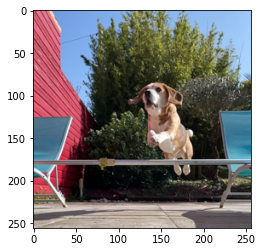

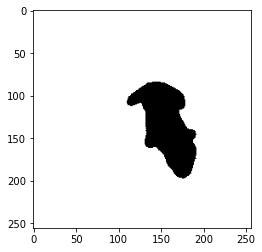

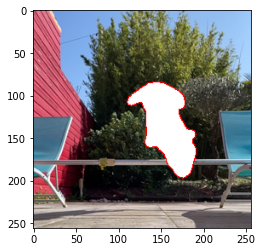

In [43]:
def disp_image(name, matrix):
    """
    :param name: files name
    :param matrix: image to display and save
    :return: display the image in a new window and save the image in the folder result
    """
    plt.figure(name)
    plt.imshow(matrix, cmap = 'Greys')
    plt.savefig("./results/"+name)
    plt.show()
    
def disp_incomplete_image(name, imgg,om,xmin,ymin,patch_dim,Xpatch,Ypatch):
    """
    Parameters
    ----------
    name : string, file name
    img : rgb image
    om : Tomega, unknown zone, binary image
 
    Returns
    -------
    None.

    """
    img = np.copy(imgg)
    shape = img.shape
    for y in range(shape[0]):
        for x in range(shape[1]):
            if (om[x][y]) :
                img[x][y] = [255,255,255]
    er = binary_erosion(om,square(3))
    front = np.array(om^er)
    for y in range(shape[0]):
        for x in range(shape[1]):
            if (front[x][y]) :
                img[x][y] = [255,0,0]
                
    for i in range(xmin-patch_dim//2, xmin+patch_dim//2+1):
        img[ymin-patch_dim//2][i] = [255,255,0]
    for i in range(xmin-patch_dim//2, xmin+patch_dim//2+1):
        img[ymin+patch_dim//2][i] = [255,255,0]
        
    for i in range(ymin-patch_dim//2, ymin+patch_dim//2+1):
        img[i][xmin-patch_dim//2] = [255,255,0]
    for i in range(ymin-patch_dim//2, ymin+patch_dim//2+1):
        img[i][xmin+patch_dim//2] = [255,255,0]
        
    for i in range(Xpatch-patch_dim//2, Xpatch+patch_dim//2+1):
        img[Ypatch-patch_dim//2][i] = [255,255,0]
    for i in range(Xpatch-patch_dim//2, Xpatch+patch_dim//2+1):
        img[Ypatch+patch_dim//2][i] = [255,255,0]
        
    for i in range(Ypatch-patch_dim//2, Ypatch+patch_dim//2+1):
        img[i][Xpatch-patch_dim//2] = [255,255,0]
    for i in range(Ypatch-patch_dim//2, Ypatch+patch_dim//2+1):
        img[i][Xpatch+patch_dim//2] = [255,255,0]
        
    plt.figure(name)
    plt.imshow(img, cmap = 'Greys')
    plt.savefig("./results/"+name)
    plt.show()
    
    
def disp_incomplete_image_bis(name, imgg, om): #permet de fournir un exemple de disp_incomplete_image
    """
    Parameters
    ----------
    name : string, file name
    img : rgb image
    om : Tomega, unknown zone, binary image
 
    Returns
    -------
    None.

    """
    img = np.copy(imgg)
    shape = img.shape
    for y in range(shape[0]):
        for x in range(shape[1]):
            if (om[x][y]) :
                img[x][y] = [255,255,255]
    er = binary_erosion(om,square(3))
    front = np.array(om^er)
    for y in range(shape[0]):
        for x in range(shape[1]):
            if (front[x][y]) :
                img[x][y] = [255,0,0]
        
    plt.figure(name)
    plt.imshow(img, cmap = 'Greys')
    plt.savefig("./results/"+name)
    plt.show()

img,name= prepare_img("./images/cooper.jpg")
om ,name_om= prepare_binary_img("./omega/cooper.jpg")
disp_incomplete_image_bis("test", img, om)

## III - Algorithme général

Après avoir implémenté ces quelques fonctions, nous allons maintenant voir comment nous avons implémenté notre algorithme. Tout d'abord, voilà l'algorithme proposé dans le document que nous avons utilisé pour notre étude :

$$ \text{Extract the manually selected initial front } \delta \Omega^{0}.$$
$$ \text{Repeat until done:} $$
$$ \text{1a. Identify the fill front } \delta \Omega^{t}\text{. If } \Omega^{t} \neq \emptyset \text{, exit.} $$
$$ \text{1b. Compute priorities } P(p) \text{ } \forall p \in \delta \Omega^{t}.$$
$$ \text{2a. Find the patch }\Psi_{\hat{p}} \text{ with the maximum priority,}$$
$$ \text{2b. Find the exemplar }\Psi_{\hat{q}} \in \Phi \text{ that minimizes } d(\Psi_{\hat{p}},\Psi_{\hat{q}}). $$
$$ \text{2c. Copy image data from } \Psi_{\hat{q}} \text{ to } \Psi_{\hat{p}}. $$
$$ \text{3. Update } C(p) \text{ } \forall p \in \Psi_{\hat{p}} \cap \Omega $$

Pour suivre l'implémentation de ce dernier que nous avons réalisé en Python, nous notifierons en haut de chaque partie à quel morceau de l'algorithme théorique elle fait référence, avec la numérotation ci-dessus (1a.b,2a.b.c,3).

Nous souhaitons présenter en premier lieu l'implémentation de l'algorithme, afin de pouvoir mieux suivre l'implémentation de chacune des sous-fonctions. Ainsi, il est normal que le code ci-dessous provoque une erreur de non-définition des fonctions si on l'exécute seul.

L'algorithme ci-dessous dispose d'un pourcentage d'avancée pour comprendre quantitativement où en est rendu l'algorithme, qui correspond au pourcentage de la zone inconnue qui a déjà été remplacée. Il y a également une estimation du temps restant qui se base sur le temps d'exécution moyen d'une étape et sur le pourcentage déjà réalisé.

In [7]:
def compute_algorithme(imgg ,om, patch_dim):
    image_size = imgg.shape[0]
    img = np.copy(imgg)
    it = 0
    om_f = np.copy(om)
    pourc = om_f.sum()
    ti = time.time()
    while (om.sum() != 0):
        t0 = time.time()
        it +=1
        front = find_fill_front(om)
        Xpatch,Ypatch = find_max_prioriy(om, image_size, patch_dim,front,img)
        patch = np.logical_not(om[Ypatch-patch_dim//2:Ypatch+patch_dim//2+1,Xpatch-patch_dim//2:Xpatch+patch_dim//2+1]) 
        xmin,ymin = find_min_distance(img,Xpatch,Ypatch,patch_dim,patch,om_f)
        img = copy_data(img,Xpatch,Ypatch,xmin,ymin,patch_dim,om)
        om = update_confidence(om,Xpatch,Ypatch,patch_dim)
        t = time.time()
        deltat = int(t-t0)
        deltati = t-ti
        p = ((1-om.sum()/pourc)*1000) # en % *10
        prev = int((100-(p/10))*deltati/(p/10))
        print("Advancement : "+str(int(p)/10)+" % (step in "+str(deltat)+"s)")
        print("Ends in "+str(prev//60)+"min"+" "+str(prev%60)+"s\n")
        disp_incomplete_image("test"+str(it), img, om,xmin,ymin,patch_dim,Xpatch,Ypatch)
    disp_image("test"+str(it+1), img)

### a) Recherche du fill front (1.a)

Nous voulons dans un premier temps nous balader sur la frontière d'omega pour déterminer le patch à remplacer. La fonction ci-dessous permet de mettre dans une liste les coordonnées des points constituant cette frontière. Nous avons utilisé la morphologie mathématique, car elle permet facilement d'obtenir le contours d'une image binaire.

In [8]:
def find_fill_front(om):
    """
    gives the coordinates of the front pixels
    """
    er = binary_dilation(om,square(3))
    front = np.array(om^er)
    shape = front.shape
    listFront = []
    for y in range (shape[0]):
        for x in range (shape[1]):
            if front[y][x] :
                listFront.append((y,x))
    return listFront

### b) Choix du pixel de priorité maximal

La clé du bon fonctionnement de l'algorithme d'inpainting est de savoir quel est le patch à traiter en premier. Pour cela, on a besoin du calcul de deux termes : le terme de confiance et le terme de données.
Le terme de confiance permet de continuer les textures, et le terme de données permet de continuer les lignes de l'image afin de conserver la géométrie de cette dernière.

#### i) Calcul du terme de confiance (1.b)

Nous nous sommes en premier lieu attardés sur le calcul du terme de confiance. En effet, en l'implémentant, nous avons eu une première version de l'algorithme fonctionnel. Ce terme permet de quantifier la connaissance que nous avons sur un patch donné, centré sur un pixel de la frontière : plus ce terme est élevé, moins il y a de pixels à remplacer dans ce patch. Nous verrons ensuite dans quel cas cette première approche est insuffisante, et nous la compléterons à l'aide du data term.

$$ C(p) = \frac{\sum_{q \in \Psi_{p} \cap \bar{\Omega}}{C(q)}}{|\Psi_{p}|}$$

Pour cela, avons besoin de créer une fonction nous permettant d'obtenir le masque afin de calculer notre terme de confiance.

In [17]:
def create_binary_mask(y,x,img_size,patch):
    """
    create mask fill with the patch centered in (x,y)
    """
    mask = np.zeros([img_size,img_size],dtype=np.uint8)
    patch_dim = patch.shape[0]
    mask[y-patch_dim//2:y+patch_dim//2+1,x-patch_dim//2:x+patch_dim//2+1] = patch
    return mask

def compute_confidence(om,front,ind,patch_dim,image_size):
    mask = create_binary_mask(front[ind][0], front[ind][1], image_size,np.ones([patch_dim,patch_dim],dtype=np.uint8))
    return ( patch_dim**2 - (om * mask).sum() )/(patch_dim**2)

def compute_data(im, front, ind,patch33,om,patch_dim,grad): #on définit ce terme de donnée temporairement pour montrer 
    return 1

Pour exemple, voici une image traité avec l'algorithme avant d'implémenter le Dataterm. On voit que le résultat est satisfaisant mais que la géométrie de  l'image n'est pas respecté. Ainsi, l'arbe semble coupé net.

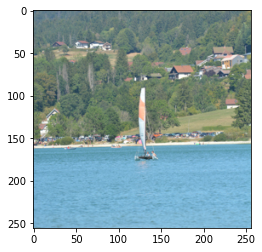

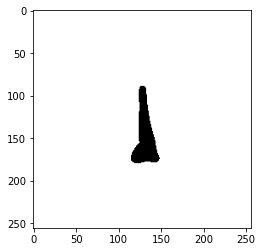

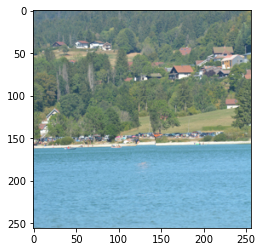

In [18]:
main_path = "./images/bateau.jpg"
omega_path = "./omega/bateau.jpg"
img,name= prepare_img(main_path)
om ,name_om= prepare_binary_img(omega_path)
compute_algorithme(img,om,15)

#### ii) Calcul du terme du data term (1.b)

Dans les cas où la géométrie de l'image présente des particularité (ligne de fuite à suivre, rayon de soleil rasant, ...), notre premier algorithme montre ses limites. En effet, on ne prend en compte qu'une distance pixel à pixel, sans considérer le gradient qui nous donne une "direction" de la lumière. Pour cela, on exploite le data term. 

$$ D(p) = \frac{|\nabla I_{p}^{\perp}.n_{p}|}{\alpha} $$

Nous voyons que ce terme est proportionnel au produit scalaire entre l'isophote et la normal à la frontière. Ainsi, les patchs priorisés seront ceux dont la géométrie de l'image "rentre" le plus perpendiculairement dans omega.

Dans un premier temps, on met en place les algorithmes permettant de réaliser un produit scalaire sur notre image, ainsi que celui permettant de calculer l'Isophote. Enfin, on applique la formule.

In [19]:
def normal_calcul(patch33):
    """
    return the normal of omega, normal vector 
    """
    top = patch33[0].sum()
    bottom = patch33[2].sum()
    left = patch33[:,0:1].sum()
    right = patch33[:,2:].sum()
    x = left - right
    y = bottom - top
    norme = np.sqrt(x**2 + y**2)
    return x/norme, y/norme

def isophote(im, front, ind,om,patch_dim,grad):
    """
    a partir de l'image en noir et blanc, on peut optimiser en faisant les couleurs
    """
    
    grad_x_sample = grad[0][front[ind][0]-patch_dim//2:front[ind][0]+patch_dim//2+1,front[ind][1]-patch_dim//2:front[ind][1]+patch_dim//2+1]
    grad_y_sample = grad[1][front[ind][0]-patch_dim//2:front[ind][0]+patch_dim//2+1,front[ind][1]-patch_dim//2:front[ind][1]+patch_dim//2+1]
    om_sample = om[front[ind][0]-patch_dim//2:front[ind][0]+patch_dim//2+1,front[ind][1]-patch_dim//2:front[ind][1]+patch_dim//2+1]


    for j in range(patch_dim):
        for i in range(patch_dim):
            if (om_sample[j][i]):
                grad_y_sample[j][i] = 0
                grad_x_sample[j][i] = 0
         
    grad_y_sample_abs = np.abs(grad_y_sample)
    grad_x_sample_abs = np.abs(grad_x_sample)
                
    ind_y = np.unravel_index(np.argmax(grad_y_sample_abs, axis=None), grad_y_sample.shape)
    ind_x = np.unravel_index(np.argmax(grad_x_sample_abs, axis=None), grad_x_sample.shape)
    x = grad_x_sample[ind_x]
    y = grad_y_sample[ind_y]
    return -y,x

def compute_data(im, front, ind,patch33,om,patch_dim,grad):

    a,b = normal_calcul(patch33)
    x,y = isophote(im, front, ind,om,patch_dim,grad)
    return abs (a*x + b*y)

Voici un exemple du même Inpainting réalisé avec Dataterm.

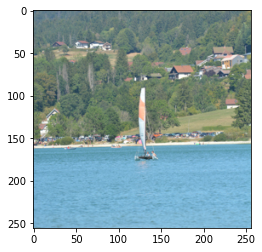

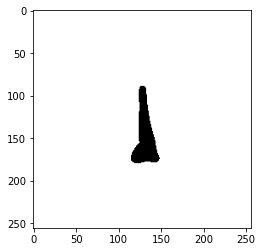

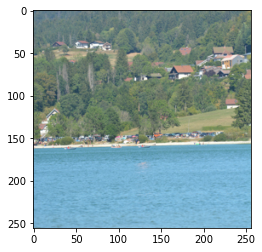

In [20]:
main_path = "./images/bateau.jpg"
omega_path = "./omega/bateau.jpg"
img,name= prepare_img(main_path)
om ,name_om= prepare_binary_img(omega_path)
compute_algorithme(img,om,15)

On voit que le résultat de l'algorithme est bien plus satisfaisant. La géométrie de l'image est bien mieux respectée, par exemple avec l'arbre qui a bien été prolongé.

#### iii) Choix du patch de priorité maximale (2.a)

On implémente alors la fonction qui permet de trouver le pixel de priorité maximale à partir des fonctions qui calculent le data term et le terme de confiance. 

In [11]:
def compute_priority(om,front,ind,patch_dim,image_size,im,grad):
    patch33 = om[front[ind][0]-1:front[ind][0]+2,front[ind][1]-1:front[ind][1]+2]
    return compute_confidence(om,front,ind,patch_dim,image_size) * compute_data(im, front, ind, patch33,om,patch_dim,grad)


def find_max_prioriy(om, image_size, patch_dim,front,im):
    xmax,ymax = -1,-1
    max_priority = 0
    r, g, b = im[:, :, 0], im[:, :, 1], im[:, :, 2]
    rgb_float = 0.2989 * r + 0.5870 * g + 0.1140 * b
    for i in range(len(rgb_float)):
        for j in range(len(rgb_float[0])):
            rgb_float[i][j] = 255-int(rgb_float[i][j]) 
    grad = np.gradient(rgb_float)
    for i in range(len(front)):
        priority = compute_priority(om,front,i,patch_dim,image_size,im,grad)
        if (priority>max_priority):
            max_priority = priority
            ymax,xmax = front[i][0], front[i][1]
    return xmax, ymax

### c) Choix du patch de distance minimale (2.b)

Nous avons obtenu notre patch à remplacer, patch de priorité maximale. Désormais, nous allons chercher le patch qui sera recopié sur le patch à remplacer. Ce patch doit être entièrement connu, il n'a donc aucune intersection avec la zone inconnue.

Pour sélectionner le patch, nous réalisons la distance euclidienne de la zone connue du patch de priorité maximale à celle des patch entièrement connus, et nous retenons le patch qui minimise cette distance.

Pour commencer, un léger traitement de notre masque représentant notre zone inconnue était nécessaire. Ainsi, La fonction ci-dessous permet de mettre le masque omega dans 3 channels (chaque channel est égal aux deux autres) afin de pouvoir le multiplier terme à terme avec une image (et donc appliquer le masque à une image).

In [12]:
def turn_omega_to_3D(mask1): 
    """
    ca ca a l'air de marcher
    """
    om_c = np.copy(mask1)
    dim = om_c.shape[0]
    mask = np.zeros([dim,dim,3],dtype=np.uint8)
    for j in range(dim):
        for i in range(dim):
            el = om_c[j][i]
            mask[j][i] = [el,el,el]
    return mask

Dans la fonction distance, nous comparons la patch sélectionné précédemment avec notre patch candidat, en ne comparant à chaque fois que les parties connues du patch. 

In [13]:
def distance(img,x,y,x2,y2,patch_dim,patch):
    sample1 = img[y-patch_dim//2:y+patch_dim//2+1,x-patch_dim//2:x+patch_dim//2+1]
    sample2 = img[y2-patch_dim//2:y2+patch_dim//2+1,x2-patch_dim//2:x2+patch_dim//2+1]
    diff = sample2-sample1
    diff_abs = np.sqrt(diff**2)
    patch_c = turn_omega_to_3D(patch)
    return (patch_c*(diff_abs)).sum()/(patch.sum())

La fonction ci dessous va servir à séléctionner le patch de remplacement. Pour ce faire, on parcourt tous les patchs passibles de l'image, on calcule la distance avec le patch que l'on souhaite remplacer, et on garde le patch de distance minimale.

Afin de diminuer la vitesse d'exécution de l'algorithme, nous avons mis en place trois optimisations dans cette fonction :
- Un seuil permettant d'estimer qu'un patch est suffisamment satisfaisant pour cesser de chercher un meilleur candidat
- Un saut de patch. On n'étudie qu'un patch sur 4, car on considère que la différence d'un patch à l'autre pour une variation de centre de 2 pixels est faible.
- On se concentre en premier lieu sur la zone voisine de Oméga, qui a davantage de chance d'être cohérente avec le patch à remplacer

Ces trois éléments ont permis de diviser par deux le temps de fonctionnement de notre algorithme lors de nos essais

In [27]:
def find_min_distance(img,Xpatch,Ypatch,patch_dim,patch,om):
    thr = 10 # On considère qu'un patch de distance < 10 est satisfaisant
    skip = 1 # On ne traite qu'un patch sur 4
    search = binary_dilation(om,square(100))
    xmin,ymin = -1,-1
    min_distance = int_inf
    for y in range(patch_dim//2,img.shape[0]-patch_dim//2-1,skip):
        for x in range(patch_dim//2,img.shape[1]-patch_dim//2,skip):
            if(om[y-patch_dim//2:y+patch_dim//2+1,x-patch_dim//2:x+patch_dim//2+1].sum()==0): 
                if (search[y][x]):
                    dist = distance(img,x,y,Xpatch,Ypatch,patch_dim,patch)
                    if (dist<min_distance):
                        min_distance = dist
                        xmin,ymin = x,y
                        if (min_distance < thr):
                            return xmin, ymin
    for y in range(patch_dim//2,img.shape[0]-patch_dim//2-1,skip):
        for x in range(patch_dim//2,img.shape[1]-patch_dim//2,skip):
            if(om[y-patch_dim//2:y+patch_dim//2+1,x-patch_dim//2:x+patch_dim//2+1].sum()==0): 
                if (search[y][x]==0):
                    dist = distance(img,x,y,Xpatch,Ypatch,patch_dim,patch)
                    if (dist<min_distance):
                        min_distance = dist
                        xmin,ymin = x,y
                        if (min_distance < thr):
                            return xmin, ymin
    return xmin, ymin

### d) Copie des données du patch remplaçant (2.c)

La fonction suivante copie les données du patch qui minimise la distance sur la partie inconnue du patch sélectionné (qui a pour coordonnées Xpatch, Ypatch).

In [15]:
def copy_data(img,Xpatch,Ypatch,x,y,patch_dim,om):
    img_c = np.copy(img)
    for j in range(Ypatch-patch_dim//2,Ypatch+patch_dim//2+2):
        for i in range(Xpatch-patch_dim//2,Xpatch+patch_dim//2+2):
            if (om[j][i]):
                img_c[j][i] = img[j+y-Ypatch][i+x-Xpatch]
    return img_c

### e) Mise à jour du terme de confiance (3)

La fonction suivante permet la mise à jour de la zone inconnue

In [16]:
def update_confidence(om,Xpatch,Ypatch,patch_dim):
    om_c = np.copy(om)
    om_c[Ypatch-patch_dim//2:Ypatch+patch_dim//2+1,Xpatch-patch_dim//2:Xpatch+patch_dim//2+1] = np.zeros([patch_dim,patch_dim],dtype=np.uint8)
    return om_c

## IV - Quelques exemples d'exécution de l'algorithme

Nous avons exécuté notre algorithme sur différentes images pour en voir les résultats.

Voici un premier exemple sur le personnage devant un lever de soleil.

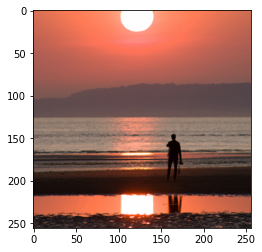

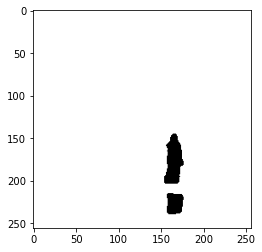

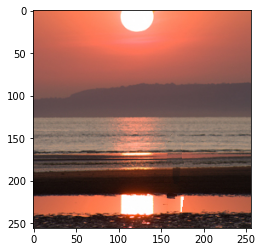

In [29]:
main_path = "./images/beach256.jpg"
omega_path = "./omega/beach256.jpg"
img,name= prepare_img(main_path)
om ,name_om= prepare_binary_img(omega_path)
compute_algorithme(img,om,15)

Nous avons aussi exécuté l'algorithme sur des sujets plus large, comme ici sur les personnages. 
Nous n'avons pas exécuté l'algorithme directement dans le Notebook car nous manquions de temps, mais l'image provient bien de notre algorithme.

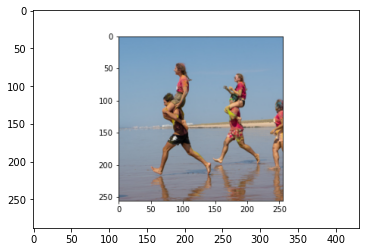

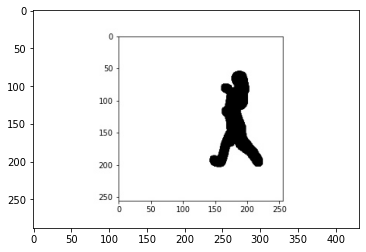

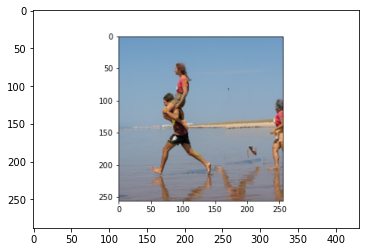

In [39]:
img,name = load_image("./rapport/beach/beach2.png")
disp_image(name, img)
img,name = load_image("./rapport/beach/beach2_mask.jpg")
disp_image(name, img)
img,name = load_image("./rapport/beach/beach2_result.png")
disp_image(name, img)

## V - Limites et éléments à fort impact

### a) Le terme de donnée parfois insuffisant pour mesurer la géométrie de l'image

Le terme de donnée ne parvient parfois pas à rendre compte de la géométrie de l'image. L'image ci-dessous illustre un cas où l'algorithme a cherché à poursuivre la géométrie créée par la planche des deux côtés de la zone à compléter. Il a donc sélectionné des patch provenant de la séparation des planches visible à côté. Mais les deux séparations ne sont pas parallèles, et la jonction a donc échoué, fournissant un résultat incohérent.

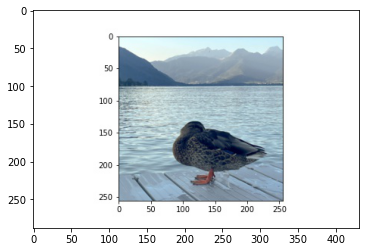

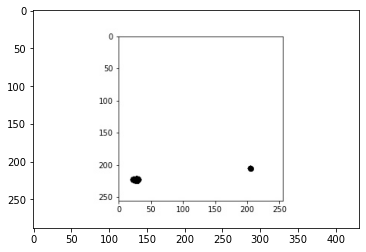

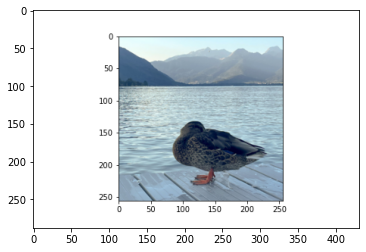

In [37]:
img,name = load_image("./rapport/duck/duck.jpg")
disp_image(name, img)
img,name = load_image("./rapport/duck/duck_mask.jpg")
disp_image(name, img)
img,name = load_image("./rapport/duck/duck_result.png")
disp_image(name, img)

### b) La taille des patch, une influence importante

Nous allons étudier l'influence de la taille du patch sur l'algorithme, avec l'exemple du bateau. Voilà le résultat de l'algorithme pour différentes tailles de patch :

Image originale


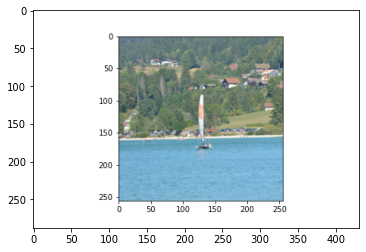

Patch 5*5 pixels


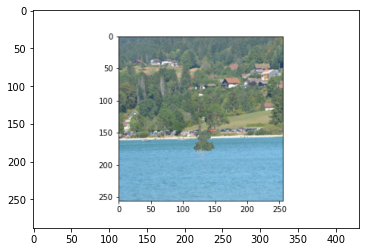

Patch 7*7 pixels


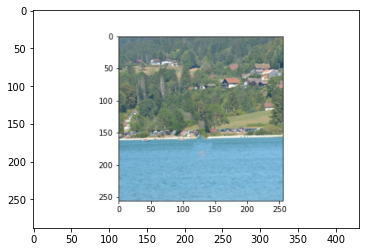

Patch 11*11 pixels


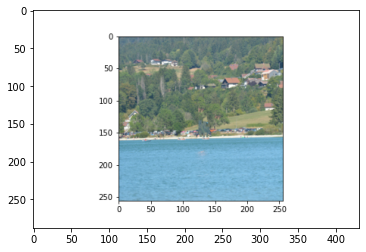

Patch 15*15 pixels


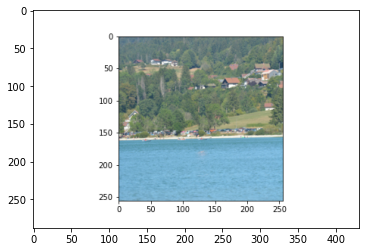

Patch 21*21 pixels


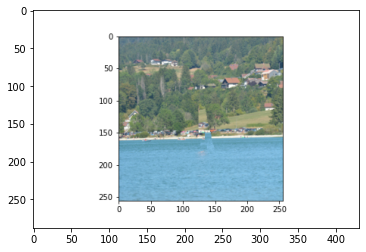

In [36]:
print("Image originale")
img,name = load_image("./rapport/bateau/bateau.png")
disp_image(name, img)
print("Patch 5*5 pixels")
img,name = load_image("./rapport/bateau/5.png")
disp_image(name, img)
print("Patch 7*7 pixels")
img,name = load_image("./rapport/bateau/7.png")
disp_image(name, img)
print("Patch 11*11 pixels")
img,name = load_image("./rapport/bateau/11.png")
disp_image(name, img)
print("Patch 15*15 pixels")
img,name = load_image("./rapport/bateau/15.png")
disp_image(name, img)
print("Patch 21*21 pixels")
img,name = load_image("./rapport/bateau/21.png")
disp_image(name, img)

On voit que lorsque la dimension du patch est trop faible (5 pixels), la dimension du patch est proche de celle des textures. Ainsi, la géométrie de l'image n'est pas considérée et le résultat est incohérent.
Lorsque la dimension du patch est trop élevée (21 pixels), l'inpainting n'est pas bon non plus. On distingue les patchs sur le résultat, ils présentent de grosse incohérence et on aperçoit ainsi nettement la forme de la zone inconnue.

Nous avons aussi relevé les temps d'exécution pour les différentes tailles de patch, disponibles ci-dessous.

$$\text{Patch 5*5 pixels : 23min et 25s}$$
$$\text{Patch 7*7 pixels : 15min et 7s}$$
$$\text{Patch 11*11 pixels : 9min et 10s}$$
$$\text{Patch 15*15 pixels : 8min et 22s}$$
$$\text{Patch 21*21 pixels : 7min et 47s}$$

On voit qu'on a une décroissance du temps d'exécution lors de l'augmentation de la taille du patch. Deux phénomènes permettent d'expliquer cette variation.

- Le nombre de patchs visités diminue lorsque la taille du patch augmente, ce qui explique cette décroissance.
- Le temps de calcul de la distance euclidienne augmente avec la taille du patch, ce qui limite cette décroissance

### c) Une vitesse d'exécution importante

Les algorithmes déterministes d'inpainting nécessitentun temps d'exécution important. Les exemples précédents nécessitent d'une dizaine de minutes à 45 minutes de temps d'exécution, pour des images 256x256 pixels, sur nos ordinateurs. Ainsi, certaines applications sont difficiles à imaginer dans de tels délais. Par exemple, réaliser différents essais lors d'une retouche d'image en HD pour retenir le plus convaincant ne semble pas accessible dans un temps raisonnable.

Certains algorithmes de machine learning permettent de réaliser de l'inpainting dans un délai bien plus faible sur des images bien mieux définis, et avec des résultats plus satisfaisants. Par exemple, certains modules sur les dernières versions de Photoshop exploitent cela. Ces concurrents aux algorithmes déterministes d'Inpainting viennent à les rendre obsolètes, tant la différence d'échelle est importante.